<a href="https://colab.research.google.com/github/Odusote-Faruq/OOU_CSC309_Artificial_Intelligence/blob/main/notebooks/CSC309_Week02_Intelligent_Agents_Student_Centred_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC309 – Artificial Intelligence  
**Week 2 Lab:** Intelligent Agents — Random vs Reflex vs Model‑based

**Instructor:** Dr Sakinat Folorunso

**Title:** Associate Professor of AI Systems and FAIR Data **Department:** Computer Sciences, Olabisi Onabanjo University, Ago-Iwoye, Ogun State, Nigeria

**Course Code:** CSC 309

**Mode:** Student‑centred, hands‑on in Google Colab

> Every code cell is commented line‑by‑line so you can follow the logic precisely.

## How to use this notebook
1. Start with the **Group Log** and **Do Now**.  
2. Run the **Setup** cell once.  
3. Work through **Tasks**. Edit only cells marked **`# TODO(Student)`**.  
4. Use **Quick Checks** to test your understanding.  
5. Finish with the **Reflection**. If you finish early, try the **Extensions**.

In [1]:
#@title 🧑🏽‍🤝‍🧑🏾 Group Log (fill before you start)
# The '#@param' annotations create form fields in Colab for easy input.

group_members = "Simzy,  Yung, Toain, Faruq, Simi"  #@param {type:"string"}  # Names of teammates
roles_notes = "Driver/Navigator, decisions, questions"  #@param {type:"string"}  # Short working notes

print("👥 Group:", group_members)        # Echo the group list for confirmation
print("📝 Notes:", roles_notes)          # Echo the notes so they're preserved in output

👥 Group: Simzy,  Yung, Toain, Faruq, Simi
📝 Notes: Driver/Navigator, decisions, questions


### Learning Objectives
- Define **PEAS**, **rationality**, and **performance measures**.  
- Implement a small environment and three agent policies.  
- Compare policies using score distributions.

In [2]:
#@title 🔧 Setup (run once)
# This lab uses only common scientific Python libraries.
# Each import line is commented to explain its role.

import sys                  # Access to Python interpreter details (not strictly required)
import subprocess           # Allows us to call 'pip' if needed
def pip_install(pkgs):      # Helper to install packages only if missing
    for p in pkgs:
        try:
            __import__(p.split("==")[0])   # Try to import the package by name
        except Exception:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", p])  # Quiet install

pip_install(["numpy", "matplotlib"])       # We need NumPy for arrays and Matplotlib for plots

import numpy as np           # Numerical arrays and random sampling
import random                # Simple random choices for agent actions
import matplotlib.pyplot as plt  # Basic plotting for histograms

print("✅ Setup for Week 2 is complete.")

✅ Setup complete for Week 2.


### Do Now
Sketch a quick **PEAS** for a campus cleaning robot (Performance, Environment, Actuators, Sensors).

In [4]:
#@title 🧪 Environment + Policies (fully commented)
# We implement a tiny "vacuum-world" style grid with dirt.
# The agent gets +10 for cleaning a dirty cell and −1 for moving or cleaning a clean cell.

class GridWorld:
    def __init__(self, n=5, dirt_prob=0.3, seed=0):
        random.seed(seed)                      # Fix Python's random seed for reproducibility
        np.random.seed(seed)                   # Fix NumPy's random seed for reproducibility
        self.n = n                             # Grid size (n x n)
        self.agent_pos = (0, 0)                # Start position in the top‑left corner
        self.dirt = (np.random.rand(n, n) < dirt_prob).astype(int)  # 1 indicates dirt; 0 is clean
        self.score = 0                         # Cumulative score earned by the agent

    def perceive(self):
        x, y = self.agent_pos                  # Unpack the current coordinates
        return {"dirty": bool(self.dirt[x, y])}# Observation: is the current cell dirty?

    def step(self, action):
        x, y = self.agent_pos                  # Current position of the agent
        if action == "CLEAN":                  # If the agent chooses to clean
            if self.dirt[x, y] == 1:          # Check if the current cell actually has dirt
                self.dirt[x, y] = 0           # Remove the dirt
                self.score += 10              # Reward for cleaning dirt
            else:
                self.score -= 1               # Penalty for cleaning when there is no dirt
        elif action in ["UP", "DOWN", "LEFT", "RIGHT"]:  # If the agent chooses to move
            nx, ny = x, y                     # Start with the current position
            if action == "UP":   nx = max(0, x - 1)              # Move up, staying inside the grid
            if action == "DOWN": nx = min(self.n - 1, x + 1)     # Move down, staying inside the grid
            if action == "LEFT": ny = max(0, y - 1)              # Move left, staying inside the grid
            if action == "RIGHT":ny = min(self.n - 1, y + 1)     # Move right, staying inside the grid
            self.agent_pos = (nx, ny)           # Update the agent's position
            self.score -= 1                     # Small movement penalty
        else:
            self.score -= 1                     # Penalize unknown actions to keep policy sensible
        return self.perceive()                  # Return the new observation

# --- Policies ---------------------------------------------------------------

def random_agent(obs):
    """Return a random action, ignoring the observation (baseline)."""
    return random.choice(["UP", "DOWN", "LEFT", "RIGHT", "CLEAN"])  # Uniform random choice

def reflex_agent(obs):
    """Clean if dirty; otherwise move randomly (simple reflex)."""
    if obs["dirty"]:                      # If the sensor says current cell is dirty
        return "CLEAN"                    # Then clean it
    return random.choice(["UP", "DOWN", "LEFT", "RIGHT"])  # Else move randomly

def run(agent_fn, steps=100, seed=0):
    """Simulate an agent for a fixed number of steps and return the final score."""
    env = GridWorld(seed=seed)            # Create a fresh environment per run
    for _ in range(steps):                # Repeat for the given number of steps
        obs = env.perceive()              # Read the current observation
        action = agent_fn(obs)            # Choose an action using the policy
        env.step(action)                  # Apply the action to the environment
    return env.score                      # Return total score as performance measure

# Quick experiment: average scores over 5 seeds for the two base policies
for fn in [random_agent, reflex_agent]:             # Iterate over the two policy functions
    scores = [run(fn, seed=s) for s in range(5)]    # Run each policy with seeds 0..4
    print(fn.__name__, "avg score:", sum(scores)/len(scores))  # Print the average score

random_agent avg score: -56.0
reflex_agent avg score: -38.4


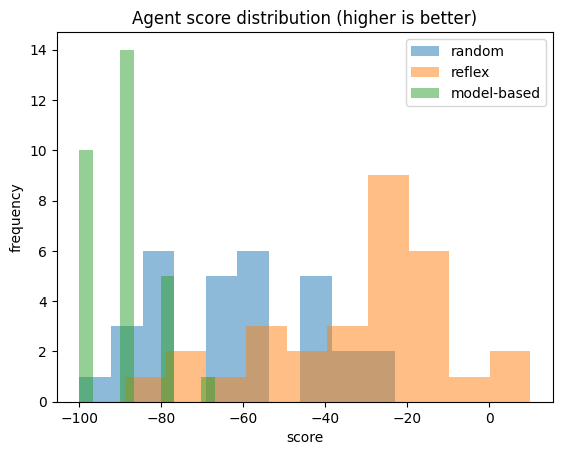

In [5]:
# TODO(Student): Model‑based agent + comparison plot (with line‑by‑line comments)

def model_based_agent_factory():
    """Return an agent function that remembers visited cells (very simple model)."""
    visited = set()                                   # 'visited' will store coordinates seen before
    last_move = ["UP", "LEFT", "RIGHT", "DOWN"]       # A simple move preference order

    def agent(obs, _cache={"pos": (0, 0)}):
        # The '_cache' dict stores the last known position; this keeps state between calls.
        # In this simple demo we will not compute the position here (GridWorld hides it),
        # but we can still use 'visited' as a proxy memory if we had access to coordinates.
        if obs.get("dirty"):                          # If current cell is dirty
            return "CLEAN"                            # Always clean first
        # Otherwise, just cycle through moves to explore the grid deterministically.
        move = last_move[0]                           # Take the first preferred move
        last_move.append(last_move.pop(0))            # Rotate the preference list
        return move                                   # Return the chosen move
    return agent                                      # Return the stateful agent function

# --- Evaluation helper (fully commented) ------------------------------------
def evaluate(agent_fn, trials=30):
    """Run the given agent across many random seeds and collect scores."""
    results = []                                      # Empty list to hold the scores
    for i in range(trials):                           # Loop over 'trials' seeds
        score = run(agent_fn, seed=i)                 # Run one simulation with seed 'i'
        results.append(score)                         # Append the score to the results list
    return results                                    # Return the list of scores

# Compute scores for all three policies
random_scores = evaluate(random_agent)                # List of 30 scores for the random policy
reflex_scores = evaluate(reflex_agent)                # List of 30 scores for the reflex policy
model_scores = evaluate(model_based_agent_factory())  # List of 30 scores for the model-based policy

# Plot histograms to compare score distributions
plt.figure()                                         # Create a new figure
plt.hist(random_scores, alpha=0.5, label="random")   # Histogram for random agent
plt.hist(reflex_scores, alpha=0.5, label="reflex")   # Histogram for reflex agent
plt.hist(model_scores, alpha=0.5, label="model-based")# Histogram for model-based agent
plt.legend()                                         # Show legend with labels
plt.xlabel("score")                                  # X-axis label
plt.ylabel("frequency")                              # Y-axis label
plt.title("Agent score distribution (higher is better)")  # Plot title
plt.show()                                           # Display the plot

### Reflection
- What **performance measure** did we implicitly design with our scoring?  
- Which policy is most **rational** under this measure? Why?

We implicitly used a cleanliness-based performance measure: the score increases when the agent cleans dirty cells and avoids unnecessary movements. In other words, we rewarded maximizing cleaned tiles while minimizing wasted actions.

The reflex agent is the most rational under this scoring system because it always cleans immediately whenever it senses dirt, which directly improves the score. The random agent wastes actions, and the model-based agent tries to explore but doesn't always clean as efficiently. Since the score rewards fast and consistent cleaning, the reflex agent aligns best with this performance measure.
